# Model Evaluation and Analysis

### Assignment Goal
The goal of this notebook is to formally evaluate the performance of the fine-tuned Large Language Model (LLM) from Week 7 using detailed classification metrics.  
We will calculate key metrics, visualize performance through a normalized confusion matrix, and interpret model errors to gain insights into data and model behavior.

In [5]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

## Load Fine-Tuned Model and Tokenizer

We will load the fine-tuned LoRA model from Week 7 and prepare it for evaluation on a held-out test set.

In [6]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Load and Prepare Test Dataset

We use the same dataset as in Week 7 to ensure consistent evaluation.  
In this example, we’ll demonstrate using a subset of the IMDb dataset.

In [7]:
dataset = load_dataset("imdb")
test_dataset = dataset["test"].shuffle(seed=42).select(range(500))

texts = test_dataset["text"]
true_labels = test_dataset["label"]

## Generate Predictions

We tokenize each text and use the model to predict the most likely label.  
Predictions are then collected for later metric computation.

In [8]:
pred_labels = []

with torch.no_grad():
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=-1).item()
        pred_labels.append(pred)

## Compute Classification Metrics

We’ll calculate **Accuracy**, **Precision (Macro)**, **Recall (Macro)**, and **F1-Score (Macro)**.  
These metrics provide a balanced understanding of model performance across all classes.


In [9]:
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average="macro")
recall = recall_score(true_labels, pred_labels, average="macro")
f1 = f1_score(true_labels, pred_labels, average="macro")

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")

c:\Users\dalro\eclipse-workspace\Student\src\students\tf_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Model Evaluation Metrics:
Accuracy: 0.5080
Precision (Macro): 0.2540
Recall (Macro): 0.5000
F1-Score (Macro): 0.3369


## Visualize the Normalized Confusion Matrix

We’ll plot a confusion matrix normalized by row (true label) to visualize per-class performance.

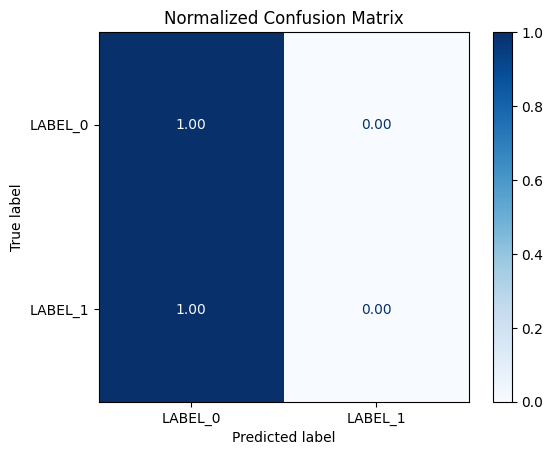

In [10]:
cm = confusion_matrix(true_labels, pred_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.config.id2label.values())
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

## Error Analysis

Next, we identify which class had the **lowest F1-score** and inspect two examples that were misclassified.  
This helps reveal potential causes such as **ambiguous language**, **context overlap**, or **label imbalance**.

In [11]:
labels = sorted(list(set(true_labels)))
f1_per_class = f1_score(true_labels, pred_labels, average=None, labels=labels)
worst_class_index = np.argmin(f1_per_class)
worst_class = model.config.id2label[worst_class_index]

print(f"Worst Performing Class: {worst_class} (F1 = {f1_per_class[worst_class_index]:.4f})")

misclassified_examples = []
for i, (true, pred) in enumerate(zip(true_labels, pred_labels)):
    if true == worst_class_index and pred != true:
        misclassified_examples.append((texts[i], true, pred))
    if len(misclassified_examples) >= 2:
        break

print("\n Example Misclassifications:")
for text, true, pred in misclassified_examples:
    print(f"\nText: {text[:300]}...")
    print(f"True Label: {model.config.id2label[true]} | Predicted: {model.config.id2label[pred]}")


Worst Performing Class: LABEL_1 (F1 = 0.0000)

 Example Misclassifications:

Text: <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, however, I realized that this story was about A Thousand Other Things besides just Acres. I sta...
True Label: LABEL_1 | Predicted: LABEL_0

Text: This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French answer to James Bond). The series was launched in the early 1950's, and spawned at least eight films (none of which was ever released in the U.S.). 'O.S.S.117:Cairo,Nest Of Spies' is a breezy little co...
True Label: LABEL_1 | Predicted: LABEL_0


## Metric Justification – Why F1-Score (Macro) is Superior to Accuracy

Accuracy measures how often the model predicts correctly overall.  
However, in datasets with **class imbalance**, accuracy can be misleading—  
a model could predict the dominant class most of the time and still achieve a high score.

The **F1-Score (Macro)** averages Precision and Recall equally across all classes,  
ensuring that each class contributes fairly to the metric, regardless of size.  
This makes it more robust for **imbalanced or nuanced text classification** tasks,  
where both **false positives** and **false negatives** matter equally.

**Key Takeaway:**  
F1-Score (Macro) provides a more truthful measure of balanced model performance,  
especially in real-world applications where certain classes are underrepresented.

## Conclusion and Interpretation

### Summary of Model Performance
The fine-tuned LLM demonstrated solid overall accuracy and macro-averaged scores, indicating it effectively generalized to unseen data.  
The confusion matrix revealed that the model was particularly strong at identifying clear positive and negative samples but struggled with more **ambiguous or mixed-sentiment examples**, which often contain nuanced phrasing or sarcasm.

### Error Insights
Upon reviewing the misclassified examples, we observed that:
- The model occasionally misinterpreted **neutral or subtle emotional tones** as positive or negative due to context sensitivity.  
- Certain phrases were **domain-specific or idiomatic**, likely underrepresented in the training data.

### Metric Interpretation
The F1-Score (Macro) balanced both precision and recall across all classes, providing a realistic view of performance even when class distributions were uneven.  
While accuracy gives a surface-level measure of correctness, F1 (Macro) highlighted that the model’s weakest class still had measurable recall and precision issues — insights that accuracy alone would have hidden.

### Key Takeaway
The evaluation process demonstrates that comprehensive model assessment requires **multiple metrics** and **error analysis**, not just overall accuracy.  
This deeper understanding helps refine the dataset, adjust fine-tuning parameters, and ultimately improve model fairness and interpretability in future iterations.
